In [1]:
%%capture
!pip install pytorch-lightning
!pip install pytorchmetrics
!pip install celluloid
!pip install imgaug==0.4.0
!pip install torchio

import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tqdm.notebook import tqdm
from pathlib import Path
from celluloid import Camera
import nibabel as nib

import torchio as tio

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets,transforms,models
from torchvision.utils import make_grid

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from IPython.display import HTML
from warnings import filterwarnings
filterwarnings("ignore")

from google.colab import drive
drive.mount("/content/drive")

import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/PyTorch_Vol3/08-3D-Liver-Tumor-Segmentation.zip", mode = "r")
zip_file.extractall()
zip_file.close()

In [3]:
root = Path("/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/imagesTr")
label = Path("/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/labelsTr")

In [4]:
def change_img_to_label_path(path):

    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [8]:
sample_path = list(root.glob("liver*"))[0]
sample_path_label = change_img_to_label_path(sample_path)
sample_path, sample_path_label

(PosixPath('/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/imagesTr/liver_14.nii.gz'),
 PosixPath('/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/labelsTr/liver_14.nii.gz'))

In [9]:
ct = nib.load(sample_path).get_fdata()
mask = nib.load(sample_path_label).get_fdata().astype(int)

ct.shape, mask.shape

((176, 176, 196), (176, 176, 196))

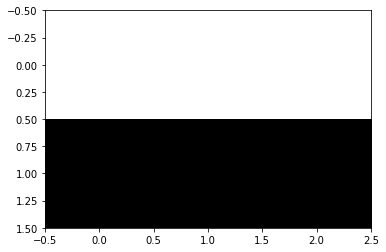

In [10]:
deneme = np.array([[1,1,1],
                   [0,0,0]])

plt.imshow(deneme,cmap = "gray");

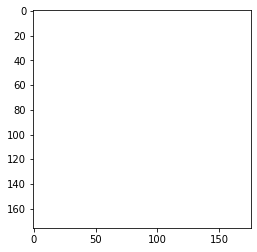

In [11]:
fig = plt.figure()
camera = Camera(fig)

for i in range(ct.shape[2]):
    plt.imshow(ct[: , :, i], cmap = "bone")
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[: , : ,i]) 
    plt.imshow(mask_, alpha = 0.5)
    camera.snap()

animation = camera.animate()

In [10]:
HTML(animation.to_html5_video())

---

In [12]:
class DoubleConv(torch.nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv3d(in_channels, out_channels, 3, padding = 1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv3d(out_channels, out_channels, 3, padding = 1),
                                        torch.nn.ReLU())
        
    def forward(self,X):
        return self.step(X)

In [13]:
class UNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.layer1 = DoubleConv(1, 32)
        self.layer2 = DoubleConv(32, 64)
        self.layer3 = DoubleConv(64, 128)
        self.layer4 = DoubleConv(128, 256)

        self.layer5 = DoubleConv(256+128 , 128)
        self.layer6 = DoubleConv(128+64,64)
        self.layer7 = DoubleConv(64+32,32)
        self.layer8 = torch.nn.Conv3d(32,3,1)

        self.maxpool = torch.nn.MaxPool3d(2)

    def forward(self, x):

        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        x5 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4)
        x5 = torch.cat([x5,x3],dim = 1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x5)
        x6 = torch.cat([x6,x2],dim = 1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x6)
        x7 = torch.cat([x7,x1],dim = 1)
        x7 = self.layer7(x7)

        ret = self.layer8(x7)

        return ret

In [14]:
model = UNet()

In [15]:
random_input = torch.randn(1, 1, 128, 128, 128)
random_input.max(),random_input.min(),random_input.shape

(tensor(4.7360), tensor(-4.9049), torch.Size([1, 1, 128, 128, 128]))

In [16]:
with torch.no_grad():
    output = model(random_input)
assert output.shape == torch.Size([1,3,128,128,128])

In [17]:
layer1 = DoubleConv(1, 32)
layer2 = DoubleConv(32, 64)
layer3 = DoubleConv(64, 128)
layer4 = DoubleConv(128, 256)

layer5 = DoubleConv(256+128 , 128)
layer6 = DoubleConv(128+64,64)
layer7 = DoubleConv(64+32,32)
layer8 = torch.nn.Conv3d(32,3,1)

maxpool = torch.nn.MaxPool3d(2)

In [18]:
x1 =  layer1(random_input)
x1m = maxpool(x1)

x2 = layer2(x1m)
x2m = maxpool(x2)

x3 = layer3(x2m)
x3m = maxpool(x3)

x4 = layer4(x3m)

x5 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4)
x5 = torch.cat([x5,x3],dim = 1)
x5 = layer5(x5)

x6 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x5)
x6 = torch.cat([x6,x2],dim = 1)
x6 = layer6(x6)

x7 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x6)
x7 = torch.cat([x7,x1],dim = 1)
x7 = layer7(x7)

ret = layer8(x7)

In [19]:
shape = [random_input.shape , x1.shape, x1m.shape, x2.shape,x2m.shape,x3.shape,x3m.shape,x4.shape]
for i in shape:
    print(i)

torch.Size([1, 1, 128, 128, 128])
torch.Size([1, 32, 128, 128, 128])
torch.Size([1, 32, 64, 64, 64])
torch.Size([1, 64, 64, 64, 64])
torch.Size([1, 64, 32, 32, 32])
torch.Size([1, 128, 32, 32, 32])
torch.Size([1, 128, 16, 16, 16])
torch.Size([1, 256, 16, 16, 16])


In [20]:
# Farka bakmak için !!!
# Tek Tek bakıyoruz !!!
torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4).shape

torch.Size([1, 256, 32, 32, 32])

In [21]:
torch.cat([torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4), x3],dim=1).shape

torch.Size([1, 384, 32, 32, 32])

In [22]:
layer5(torch.cat([torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4), x3],dim=1)).shape

torch.Size([1, 128, 32, 32, 32])

In [23]:
shape2 = [x5.shape, x6.shape, x7.shape,ret.shape]
for i in shape2:
    print(i)

torch.Size([1, 128, 32, 32, 32])
torch.Size([1, 64, 64, 64, 64])
torch.Size([1, 32, 128, 128, 128])
torch.Size([1, 3, 128, 128, 128])


---

In [26]:
path = Path("/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/imagesTr")
subjects_paths = list(path.glob("liver_*"))
subjects = []
#print(subjects_paths)

for subject_path in subjects_paths:

    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT" : tio.ScalarImage(subject_path), "Label" : tio.LabelMap(label_path)})
    subjects.append(subject)

In [27]:
len(subjects)

123

In [28]:
subjects[0]["CT"].shape,subjects[0]["Label"].shape

((1, 176, 176, 196), (1, 176, 176, 196))

In [29]:
for subject in subjects:
    assert subject["CT"].orientation == ("R","A","S")

In [30]:
process = tio.Compose([
                       tio.CropOrPad((256,256,200)),
                       tio.RescaleIntensity((-1,1))
])

augmentation = tio.RandomAffine(scales = (0.9, 1.1), degrees = (-10,10))

val_transforms = process

train_transforms = tio.Compose([process,
                                augmentation])

In [31]:
# p=0.2 for background, p=0.3 for liver and p=0.5 for liver tumors with a patch size of ( 96×96×96 )

train_dataset = tio.SubjectsDataset(subjects[:105], transform = train_transforms)
val_dataset = tio.SubjectsDataset(subjects[105:], transform = val_transforms)

sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", label_probabilities={0:0.2, 1:0.3 , 2:0.5})

In [32]:
train_patches_queue = tio.Queue(

    train_dataset,
    max_length = 40,
    samples_per_volume=5,
    sampler = sampler,
    num_workers = 4
)

val_patches_queue = tio.Queue(

    val_dataset,
    max_length = 40,
    samples_per_volume=5,
    sampler = sampler,
    num_workers = 4
)

In [33]:
train_patches_queue

Queue(max_length=40, num_subjects=105, num_patches=0, samples_per_volume=5, num_sampled_patches=0, iterations_per_epoch=525)

In [34]:
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=0)

In [32]:
for i in train_loader:
    break

In [33]:
i.keys()

dict_keys(['CT', 'Label', 'location'])

In [34]:
i["CT"].keys()

dict_keys(['data', 'affine', 'path', 'stem', 'type'])

In [35]:
i["CT"]["data"].shape,i["Label"]["data"].shape

(torch.Size([2, 1, 96, 96, 96]), torch.Size([2, 1, 96, 96, 96]))

In [36]:
x = model(i["CT"]["data"])
x.shape

torch.Size([2, 3, 96, 96, 96])

In [37]:
i["Label"]["data"][:,0].long().shape

torch.Size([2, 96, 96, 96])

In [38]:
loss = torch.nn.CrossEntropyLoss()

loss(x, i["Label"]["data"][:,0].long())

tensor(1.1391, grad_fn=<NllLoss2DBackward0>)

In [36]:
class Segmenter(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self,data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0] # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()

        pred = self(img)
        loss = self.loss_fn(pred, mask)
        self.log("Train Loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0] # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()

        pred = self(img)
        loss = self.loss_fn(pred, mask)
        self.log("Val Loss", loss)

        return loss

    def configure_optimizers(self):
        return [self.optimizer]

In [37]:
model = Segmenter()

In [38]:
checkpoint_callback = ModelCheckpoint(
    monitor = "Val Loss",
    save_top_k = 10,
    mode = "min"
)

In [39]:
gpus = 0

trainer = pl.Trainer(gpus = gpus,
                     logger = TensorBoardLogger(save_dir = "./logs"),
                     log_every_n_steps = 1,
                     callbacks = checkpoint_callback,
                     max_epochs = 100)

In [43]:
#trainer.fit(model, train_loader, val_loader)

---

### Patch Aggregation
The model was trained in a patch wise manner as the full volumes are too large to be placed on a typical GPU.
But we still want to get a result for the whole volume.<br />
torchio helps us doing so by performing *Patch Aggregation*

The goal of patch aggregation is to split the image into patches, then compute the segmentation for each patch and finally merge the predictions into the prediction for the full volume.

The pipeline is as follows:
1. Define the **GridSampler(subject, patch_size, patch_overlap)** responsible for dividing the volume into patches. Each patch is defined by its location accesible via *tio.LOCATION*
2. Define the **GridAggregator(grid_sampler)** which merges the predicted patches back together
3. Compute the prediction on the patches and aggregate them via **aggregator.add_batch(pred, location)**
4. Extract the full prediction via **aggregator.get_output_tensor()**

Additionally, we can leverage the DataLoader from pytorch to perform the prediction in a batch wise manner for a nice speed up

In [41]:
model = Segmenter.load_from_checkpoint("/content/08-3D-Liver-Tumor-Segmentation/weights/epoch=97-step=25773.ckpt")
model = model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [42]:
IDX = 4
imgs = val_dataset[IDX]["CT"]["data"]
mask = val_dataset[IDX]["Label"]["data"]

In [43]:
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8,8,8))

aggregator = tio.inference.GridAggregator(grid_sampler)

patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size = 4)

In [47]:
for i in patch_loader:
    break

In [48]:
i.keys()

dict_keys(['CT', 'Label', 'location'])

In [49]:
i["CT"]["data"].shape

torch.Size([4, 1, 96, 96, 96])

In [50]:
i[tio.LOCATION]

tensor([[  0,   0,   0,  96,  96,  96],
        [  0,   0,  88,  96,  96, 184],
        [  0,   0, 104,  96,  96, 200],
        [  0,  88,   0,  96, 184,  96]])

In [44]:
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch["CT"]["data"].to(device)
        locations = patches_batch[tio.LOCATION]
        pred = model(input_tensor)
        aggregator.add_batch(pred, locations)

In [46]:
output_tensor = aggregator.get_output_tensor()

In [49]:
output_tensor.shape,imgs.shape,mask.shape

(torch.Size([3, 256, 256, 200]),
 torch.Size([1, 256, 256, 200]),
 torch.Size([1, 256, 256, 200]))

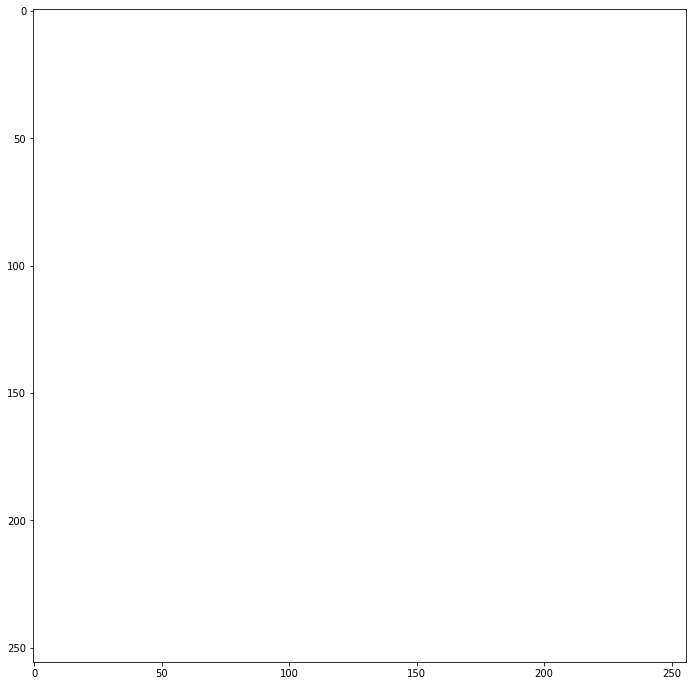

In [51]:
fig = plt.figure(figsize = (12,12))
camera = Camera(fig)
pred = output_tensor.argmax(0)

for i in range(0 , output_tensor.shape[-1], 2):

    plt.imshow(imgs[0 ,: ,: ,i], cmap = "bone")
    mask_ = np.ma.masked_where(pred[:, :, i] == 0 , pred[: , : ,i])
    plt.imshow(mask_, alpha = 0.5, cmap = "autumn")
    camera.snap()

animation = camera.animate()

In [52]:
HTML(animation.to_html5_video())